<a href="https://colab.research.google.com/github/hungryPanko/MultipleObjectDetection/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# To Do 
- CNN) Try to implement HW4 SimpleCNN - Derek
- CNN) Try to implement Resnet-RCNN - Hanna 
- Testing for multiple objects - Ray
- Output)Check how to measure the performance of multiple obj detection - Ray
- Documentation - Hanna
- Github update - Hanna

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup

from PIL import Image
import cv2
import numpy as np
import time
import random
import shutil

import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import albumentations as A
from albumentations.pytorch import ToTensorV2

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/SignalDetection2
torch.cuda.is_available()  # Go to Menu > Runtime > Change runtime to GPU

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/SignalDetection2


True

In [2]:
img_list = sorted(glob.glob('./input/images/*'))
annot_list = sorted(glob.glob('./input/annotations/*'))

In [3]:
print(len(img_list))
print(len(annot_list))
print(img_list[:10])
print(annot_list[:10])

707
707
['./input/images/road0.png', './input/images/road1.png', './input/images/road10.png', './input/images/road100.png', './input/images/road101.png', './input/images/road103.png', './input/images/road105.png', './input/images/road106.png', './input/images/road107.png', './input/images/road108.png']
['./input/annotations/road0.xml', './input/annotations/road1.xml', './input/annotations/road10.xml', './input/annotations/road100.xml', './input/annotations/road101.xml', './input/annotations/road103.xml', './input/annotations/road105.xml', './input/annotations/road106.xml', './input/annotations/road107.xml', './input/annotations/road108.xml']


In [4]:
# Seperate Data
print(len(os.listdir('./input/images')))
print(len(os.listdir('./input/annotations')))

!mkdir test_images
!mkdir test_annotations

if (len(os.listdir('./input/images')) == len(os.listdir('./input/annotations')) == 877):
    #total of 877 images, We use 170 image as validation 
    random.seed(1234)
    idx = random.sample(range(877), 170) #707+170=877
    for img in np.array(sorted(os.listdir('./input/images')))[idx]:
        shutil.move('./input/images/'+img, './test_images/'+img)
    for annot in np.array(sorted(os.listdir('./input/annotations')))[idx]:
        shutil.move('./input/annotations/'+annot, './test_annotations/'+annot)
else: 
    print("Data already seperated")

print(len(os.listdir('./input/annotations')))
print(len(os.listdir('./input/images')))
print(len(os.listdir('./test_annotations')))
print(len(os.listdir('./test_images')))

707
707
mkdir: cannot create directory ‘test_images’: File exists
mkdir: cannot create directory ‘test_annotations’: File exists
Data already seperated
707
707
170
170


In [36]:
def generate_box(obj):
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    return [xmin, ymin, xmax, ymax]

def generate_label(obj, label_adjust=None):
    label_adjust = 1 if label_adjust else 0 
    #label: RetinaNet[0~N], Fast CNN[1~N], 
    if obj.find('name').text == "speedlimit":
        return 0 + label_adjust
    elif obj.find('name').text == "stop":
        return 1 + label_adjust
    elif obj.find('name').text == "crosswalk":
        return 2 + label_adjust
    elif obj.find('name').text == "trafficlight":
        return 3 + label_adjust

def generate_target(file, model=None): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")
        num_objs = len(objects)
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i,label_adjust=model))
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        return target

def plot_image(img_path, annotation):
    img = mpimg.imread(img_path)
    fig,ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='r',facecolor='none')
        elif annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='g',facecolor='none')
        elif annotation['labels'][idx] == 2 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='b',facecolor='none')
        elif annotation['labels'][idx] == 3 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='yellow',facecolor='none')
        else:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

def plot_image_from_output(img, annotation):
    img = img.permute(1,2,0)
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]
        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='r',facecolor='none')
        elif annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='g',facecolor='none')
        elif annotation['labels'][idx] == 2 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='b',facecolor='none')
        elif annotation['labels'][idx] == 3 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='yellow',facecolor='none')
        else:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='orange',facecolor='none')
        ax.add_patch(rect)
    plt.show()

167 ./input/annotations/road300.xml


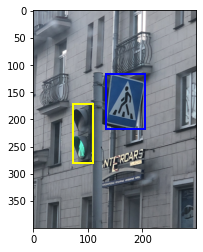

In [37]:
n = img_list.index('./input/images/road300.png')
print(n, annot_list[n])
bbox = generate_target(annot_list[n])
plot_image(img_list[n], bbox)

259 ./input/annotations/road40.xml


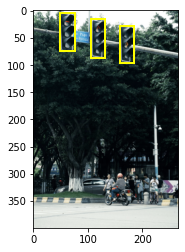

In [38]:
n = img_list.index('./input/images/road40.png')
print(n, annot_list[n])
bbox = generate_target(annot_list[n])
plot_image(img_list[n], bbox)

# Data Augmentation and Loading

In [41]:
# Data Augmentation
train_transform = A.Compose([ 
    A.Resize(300, 300),
    A.Affine(rotate=5, shear=10),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2()],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
)

valid_transform = A.Compose([ 
    A.Resize(300, 300),
    ToTensorV2()],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
)

In [42]:
# Data Loader
class SignalDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("./test_annotations/", file_label)
        else:
            label_path = os.path.join("./input/annotations/", file_label)

        target = generate_target(label_path)
        
        if self.transform:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            transformed = self.transform(image=img, bboxes=target['boxes'], labels=target['labels'])
            img = transformed['image']/255  #RetinaNet input [0-1]
            target = {'boxes':torch.as_tensor(transformed['bboxes']), \
                      'labels':torch.as_tensor(transformed['labels'])}  
        else:
            img = Image.open(img_path).convert("RGB")
            to_tensor = torchvision.transforms.ToTensor()    
            img = to_tensor(img)

        return img, target

def collate_fn(batch):
    return tuple(zip(*batch))

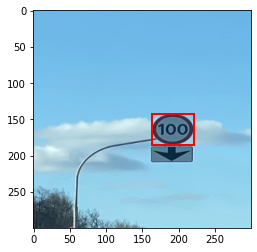

In [40]:
# Test ouput
bbox_transform_dataset = SignalDataset(
    path = './input/images/',
    transform = train_transform
)
img, annot = bbox_transform_dataset[261]
plot_image_from_output(img, annot)

In [17]:
dataset = SignalDataset('./input/images/', transform=train_transform)
test_dataset = SignalDataset('./test_images/', transform=valid_transform)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

In [19]:
# Check out for the output for the batch iteration. 
train_features, train_annotations = next(iter(data_loader))
print(train_features[0].shape)
print(train_annotations)
print(train_annotations[0])
print(train_annotations[0]['boxes'], train_annotations[0]['labels'])
print(train_features[0][0:10])

torch.Size([3, 300, 300])
({'boxes': tensor([[ 65.3305,  28.6576, 214.0298, 183.1524]], dtype=torch.float64), 'labels': tensor([3])}, {'boxes': tensor([[ 70.9073,  58.4461, 203.7363, 300.0000]], dtype=torch.float64), 'labels': tensor([3])}, {'boxes': tensor([[117.0000,   3.3708, 220.5000, 295.5056]], dtype=torch.float64), 'labels': tensor([3])}, {'boxes': tensor([[ 27.7500,   3.8961, 273.7500, 254.0260]], dtype=torch.float64), 'labels': tensor([0])}, {'boxes': tensor([[  0.0000,   0.0000, 189.5182, 287.0026]], dtype=torch.float64), 'labels': tensor([0])}, {'boxes': tensor([[ 66.7500,  24.9169, 222.7500, 271.0963]], dtype=torch.float64), 'labels': tensor([0])}, {'boxes': tensor([[ 24.4729,  77.5194, 300.0000, 300.0000]], dtype=torch.float64), 'labels': tensor([0])}, {'boxes': tensor([[116.8539, 112.5000, 186.5169, 169.5000]], dtype=torch.float64), 'labels': tensor([0])}, {'boxes': tensor([[ 57.0242,  14.4185, 220.3746, 189.6785]], dtype=torch.float64), 'labels': tensor([0])}, {'boxes': 

# Transfer Learning: RetinaNet

In [20]:
# Number of classes = 4 (4 classes)
retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes=4, pretrained=False, pretrained_backbone = True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and will be removed in 0.15, please use 'weights_backbone' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight

  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [22]:
# For the first training
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_epochs = 30 # To do
retina.to(device)

# If we have saved the training model, load it
#num_epochs = 30 # To do
#retina.load_state_dict(torch.load(f'retina_{num_epochs}.pt'))
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#retina.to(device)

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, e

In [28]:
# parameters
params = [p for p in retina.parameters() if p.requires_grad] # select parameters that require gradient calculation
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

# about 4 min per epoch on Colab GPU
for epoch in range(num_epochs):
    start = time.time()
    retina.train()

    i = 0    
    epoch_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = retina(images, targets) 
        losses = sum(loss for loss in loss_dict.values()) 
        i += 1
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        epoch_loss += losses 
    print(epoch_loss, f'time: {time.time() - start}')

tensor(74.9954, device='cuda:0', grad_fn=<AddBackward0>) time: 412.08177185058594
tensor(75.6373, device='cuda:0', grad_fn=<AddBackward0>) time: 107.05234265327454


In [ ]:
# Save/Load the model
#torch.save(retina.state_dict(),f'retina_{num_epochs}.pt')

In [29]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []
        
        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : #select idx which meets the threshold
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [30]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(retina, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 85/85 [05:12<00:00,  3.67s/it]


In [31]:
def plot_image_from_output(img, annotation):
    img = img.cpu().permute(1,2,0)
    
    rects = []

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='r',facecolor='none')
        elif annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='g',facecolor='none')
        elif annotation['labels'][idx] == 2 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='b',facecolor='none')
        elif annotation['labels'][idx] == 3 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='yellow',facecolor='none')
        else:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='orange',facecolor='none')

        rects.append(rect)

    return img, rects


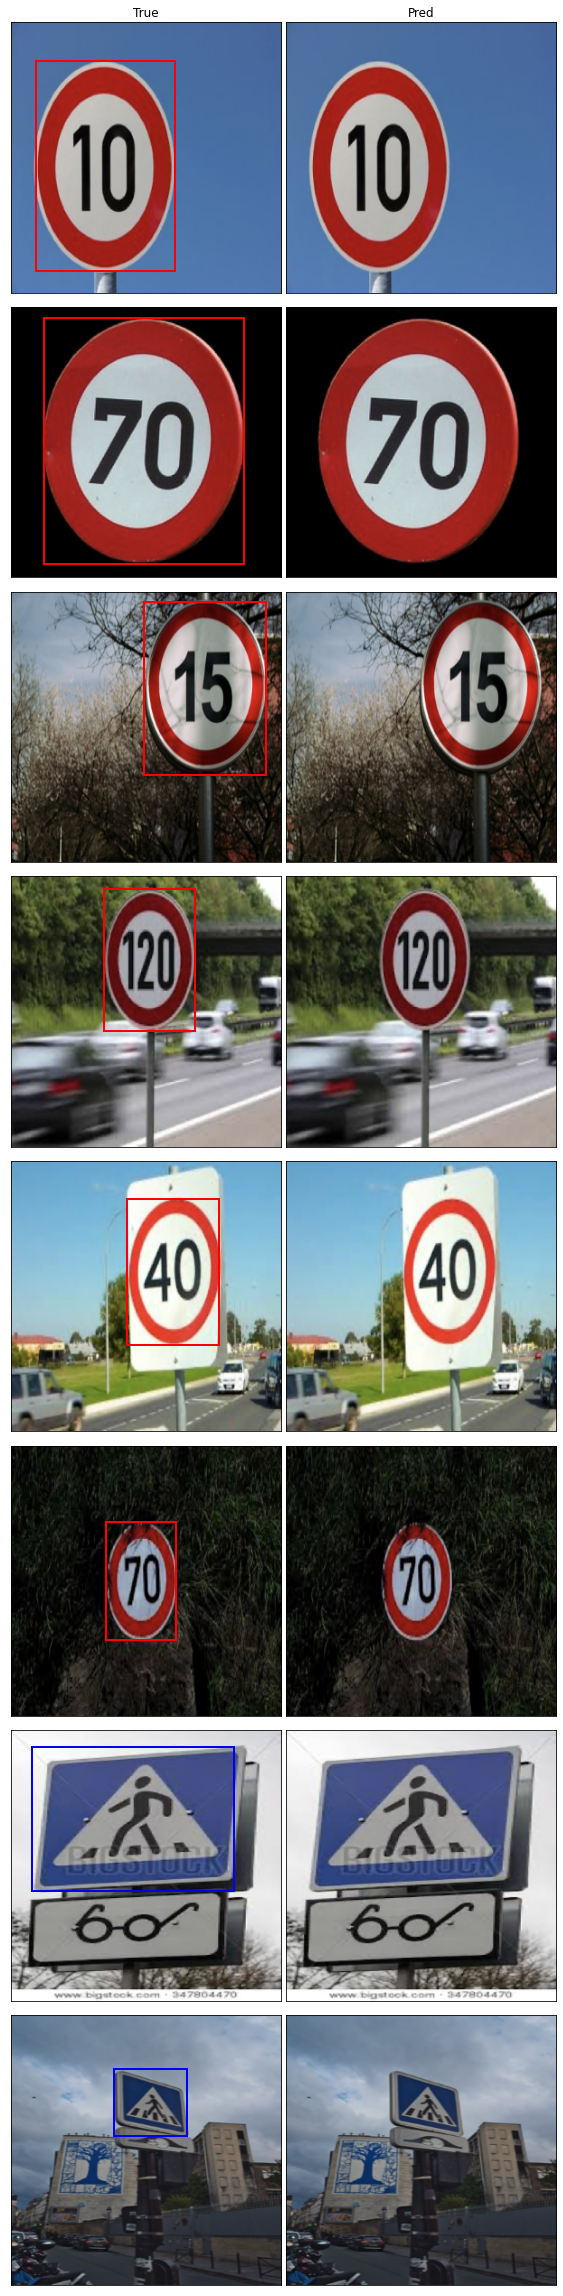

In [32]:
nrows = 8
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))

batch_i = 0
for im, annot in test_data_loader:
    pos = batch_i * 4 + 1
    for sample_i in range(len(im)) :
        img, rects = plot_image_from_output(im[sample_i], annot[sample_i])
        axes[(pos)//2, 1-((pos)%2)].imshow(img)
        for rect in rects:
            axes[(pos)//2, 1-((pos)%2)].add_patch(rect)
        
        img, rects = plot_image_from_output(im[sample_i], preds_adj_all[batch_i][sample_i])
        axes[(pos)//2, 1-((pos+1)%2)].imshow(img)
        for rect in rects:
            axes[(pos)//2, 1-((pos+1)%2)].add_patch(rect)
        pos += 2

    batch_i += 1
    if batch_i == 4:
        break

# remove xtick, ytick
for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

colnames = ['True', 'Pred']

for idx, ax in enumerate(axes[0]):
    ax.set_title(colnames[idx])

plt.tight_layout()
plt.show()

# Transfer Learning: Fast RCNN